<a href="https://colab.research.google.com/github/r2klabs/CS430Repository/blob/main/SupportVectorMachine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Support Vector Machines
This notebook was developed to demonstrate the fundamental concepts of Support Vector Machines using SKLearn.

## Importing libraries
These are the standard libraries will will always import into our notebooks.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

These imports are specific to performing Linear Regression using the SKLearn and statsmodels libraries

In [ ]:
from sklearn.svm import SVC, SVR, LinearSVC, LinearSVR

These imports are for building the transformers, the pipeline, and splitting the data.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split

These imports are for various performance measures to evaluate our model.

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

Set the config option to display the pipeline diagram.

In [ ]:
from sklearn import set_config
set_config(display='diagram')

This function is used to plot the confusion matrix.

In [ ]:
def plot_cm(y_test, y_pred):
    cm = confusion_matrix(y_test,y_pred)
    fig = plt.figure(figsize=(10,10))
    heatmap = sns.heatmap(cm, annot=True, fmt='.2f', cmap='RdYlGn')
    plt.ylabel('True label')
    plt.xlabel('Predicted Label')

## Connect to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


The function below plots a straight line on a plot.


In [ ]:
def abline(slope, intercept,color):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', c=color)

The function below will be used to draw the margins similar to the plots in the book.

In [ ]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
  
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

This cell creates a small linear data set that we can plot for example purposes. This is similar to the example in the book.

In [ ]:
X = np.linspace(-10, 10, num=10)
y = X
outcome = [1,1,1,1,1,0,0,0,0,0]
data = np.concatenate((X.reshape(10,1), y.reshape(10,1)), axis=1)
df = pd.DataFrame(data)
df.rename(columns={0:'x',1:'y'}, inplace=True)
df['outcome'] = outcome

In [ ]:
df

,x,y,outcome
0,-10.000000,-10.000000,1
1,-7.777778,-7.777778,1
2,-5.555556,-5.555556,1
3,-3.333333,-3.333333,1
4,-1.111111,-1.111111,1
5,1.111111,1.111111,0
6,3.333333,3.333333,0
7,5.555556,5.555556,0
8,7.777778,7.777778,0
9,10.000000,10.000000,0


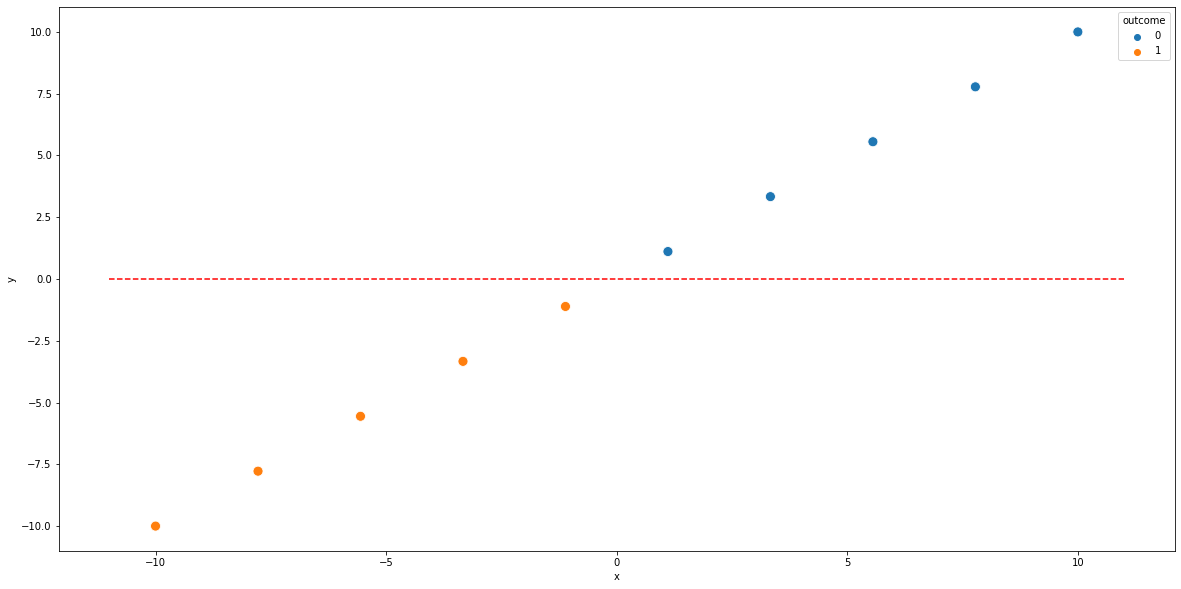

In [ ]:
fig = plt.figure(figsize=(20,10))
sns.scatterplot(data=df, x='x', y='y', hue='outcome', s=100)
abline(0,0, 'red')

In [ ]:
X = np.linspace(-10, 10, num=10)
y = X
outcome = [1,1,1,0,0,0,0,1,1,1]
data = np.concatenate((X.reshape(10,1), y.reshape(10,1)), axis=1)
df = pd.DataFrame(data)
df.rename(columns={0:'x',1:'y'}, inplace=True)
df['outcome'] = outcome

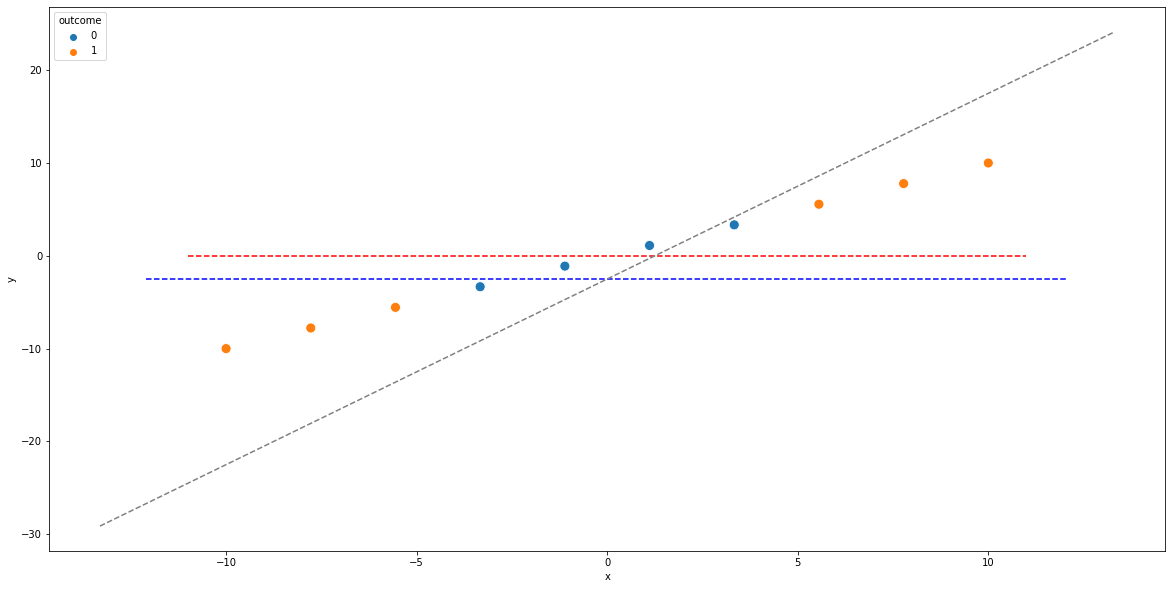

In [ ]:
fig = plt.figure(figsize=(20,10))
sns.scatterplot(data=df, x='x', y='y', hue='outcome', s=100)
abline(0,0,'red')
abline(0, -2.5, 'blue')
abline(2, -2.5, 'gray')

Now let's add a term to the model with $ X^2 $

In [ ]:
X = np.linspace(-10, 10, num=10)
y = X + X**2
outcome = [1,1,1,0,0,0,0,1,1,1]
data = np.concatenate((X.reshape(10,1), y.reshape(10,1)), axis=1)
df = pd.DataFrame(data)
df.rename(columns={0:'x',1:'y'}, inplace=True)
df['outcome'] = outcome

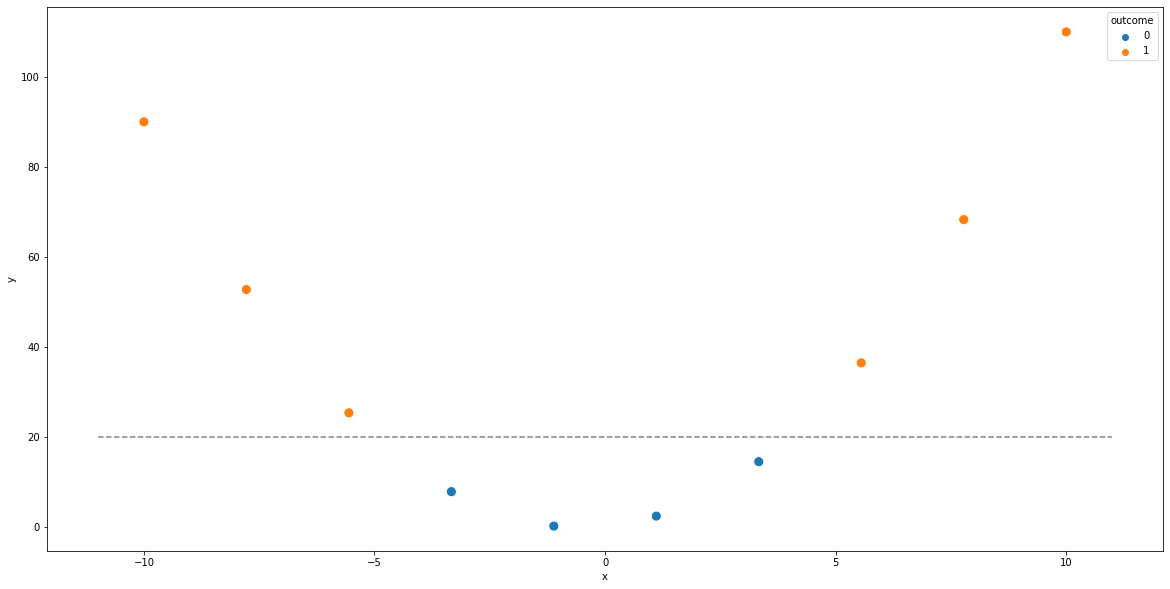

In [ ]:
fig = plt.figure(figsize=(20,10))
sns.scatterplot(data=df, x='x', y='y', hue='outcome', s=100)
abline(0, 20, 'gray')

The line that separates the points is actually called a **separating** hyperplane.  Imagine the line was really a sheet of paper that you slide between the points to separate them.

These functions let us generate data sets that have a particular distribution so we can test various classification algorithms.  This is useful for viewing the capabilities of SVM.

In [ ]:
from sklearn.datasets import make_classification, make_moons, make_blobs, make_circles
n_samples = 10000
X,y = make_circles(random_state=4, noise=.05,n_samples=n_samples, factor = .4)

In [ ]:
df = pd.DataFrame(np.hstack((X, y.reshape(n_samples,1))))
df.rename(columns={0:'X',1:'Y',2:'Outcome'}, inplace=True)

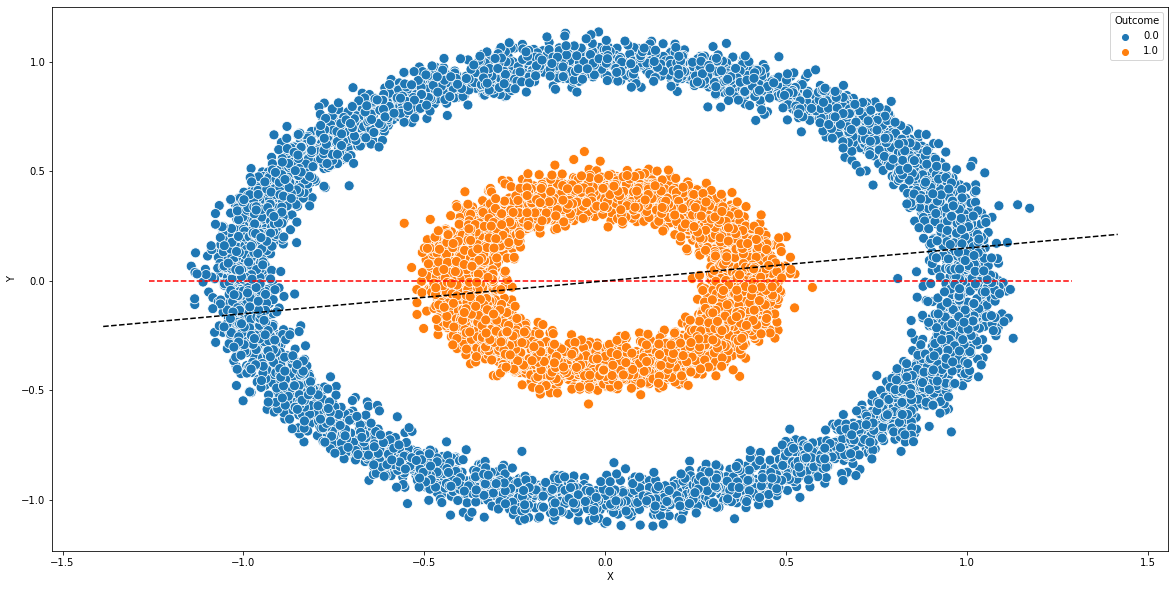

In [ ]:
fig = plt.figure(figsize=(20,10))
sns.scatterplot(data=df, x='X', y='Y', hue='Outcome', s=100)
abline(0, 0, 'red')
abline(.15, 0, 'black')

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.20, random_state=32)

In [ ]:
logit_model = LogisticRegression()
logit_model.fit(X_train, y_train)
y_pred = logit_model.predict(X_test)

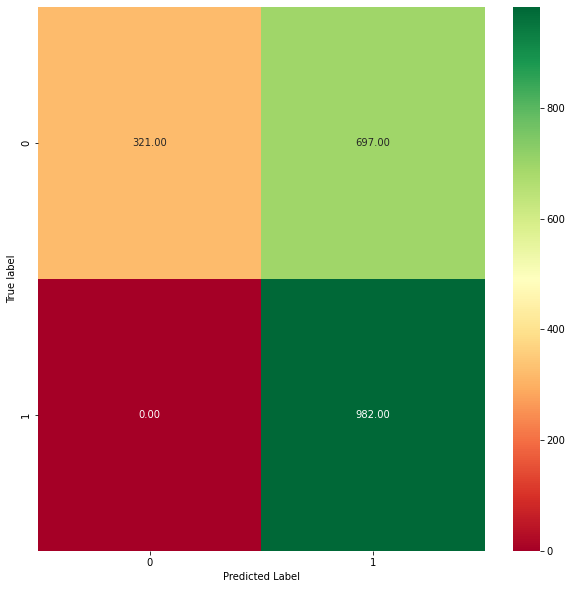

In [ ]:
plot_cm(y_test,y_pred)

In [ ]:
print(precision_score(y_test,y_pred))
print(recall_score(y_test,y_pred))
print(f1_score(y_test,y_pred))

0.5848719475878499
1.0
0.7380683953400977


Support Vector machines use kernels (the kernel trick) that transform the data during the classification process. The options are: 'linear', 'poly', 'rbf', 'sigmoid', or 'precomputed'.   
C is a regularization parameter. 1 is a good place to start. Larger values may cause you to overfit.

In [ ]:
model = SVC(kernel="poly", degree=2, C=1, max_iter=100000)
model.fit(X_train,y_train)

SVC(C=1, degree=2, kernel='poly', max_iter=100000)

In [ ]:
y_pred = model.predict(X_test)

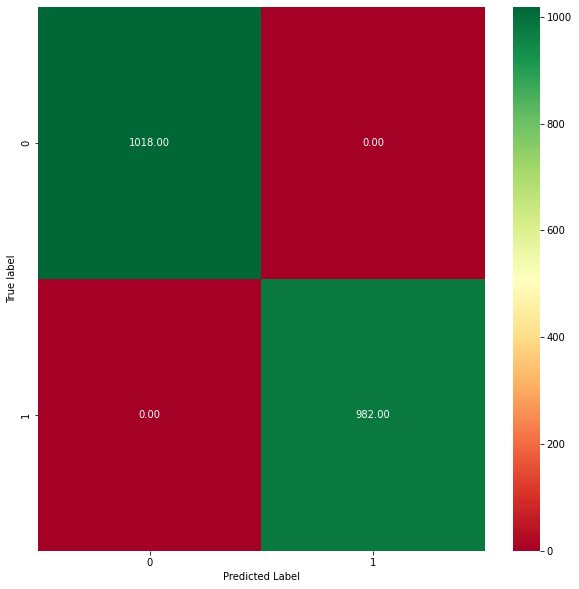

In [ ]:
plot_cm(y_test,y_pred)

In [ ]:
print(precision_score(y_test,y_pred))
print(recall_score(y_test,y_pred))
print(f1_score(y_test,y_pred))

1.0
1.0
1.0


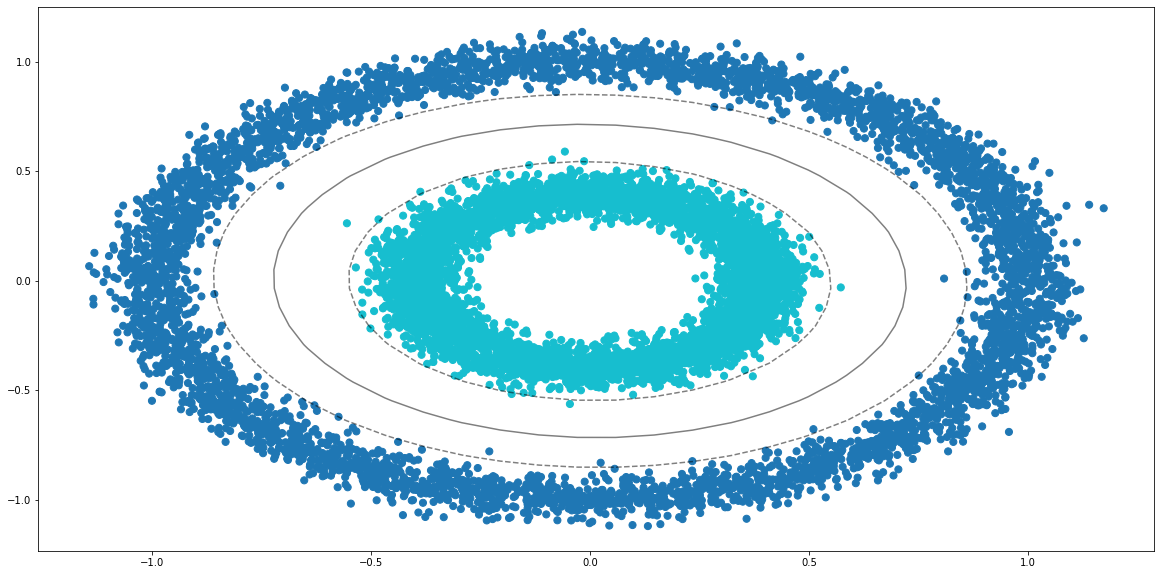

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='tab10') 
plot_svc_decision_function(model);

## Reading the data set

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/CS430/processed_penguins.csv')  

In [ ]:
df.head()

,study_name,species,island,clutch_completion,date_egg,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,delta_15,delta_13,study_day
0,PAL0708,Adelie,Torgersen,Yes,2007-11-11,39.5,17.4,186.0,3800.0,FEMALE,8.94956,-24.69454,2
1,PAL0708,Adelie,Torgersen,Yes,2007-11-16,40.3,18.0,195.0,3250.0,FEMALE,8.36821,-25.33302,7
2,PAL0708,Adelie,Torgersen,Yes,2007-11-16,36.7,19.3,193.0,3450.0,FEMALE,8.76651,-25.32426,7
3,PAL0708,Adelie,Torgersen,Yes,2007-11-16,39.3,20.6,190.0,3650.0,MALE,8.66496,-25.29805,7
4,PAL0708,Adelie,Torgersen,No,2007-11-15,38.9,17.8,181.0,3625.0,FEMALE,9.18718,-25.21799,6


You can choose your color palette for Seaborn. Info can be found at: https://seaborn.pydata.org/tutorial/color_palettes.html.

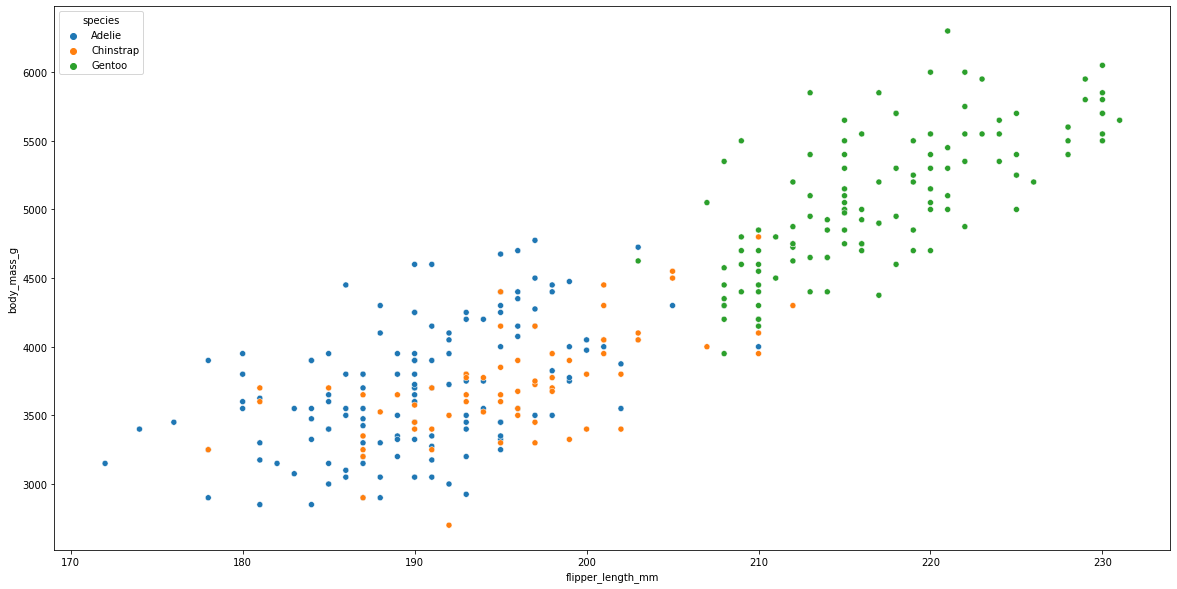

In [ ]:
sns.color_palette("dark")
fig = plt.figure(figsize=(20,10))
sns.scatterplot( x='flipper_length_mm', y='body_mass_g', data=df, hue='species')

In [ ]:
df['size']=df['species'].apply(lambda x: 1 if x == "Gentoo" else 0) 

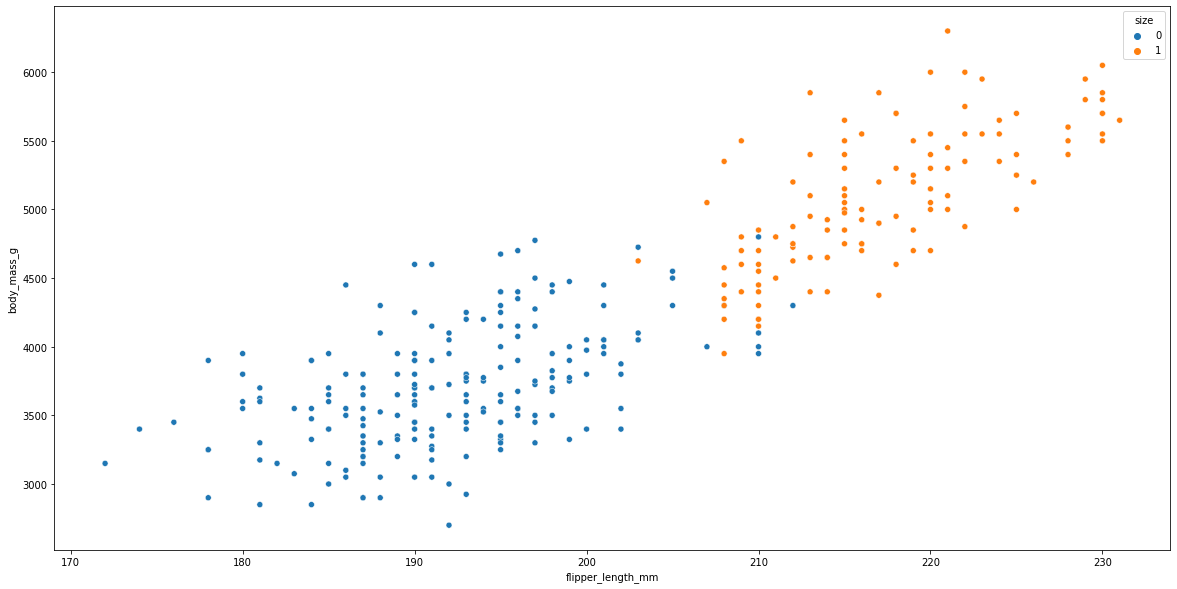

In [ ]:
fig = plt.figure(figsize=(20,10))
sns.scatterplot( x="flipper_length_mm", y="body_mass_g", data=df, hue='size')

Let's drop the columns we won't be using for sure.

In [ ]:
df.drop(['study_name','island','clutch_completion','date_egg','study_day'], axis=1, inplace=True)

## Split into Train/Test - First Iteration
We are going to split into Train/Test with only flipper length and body mass as our input variables and size as our target variable.

In [ ]:
df.head()

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,delta_15,delta_13,size
0,Adelie,39.5,17.4,186.0,3800.0,FEMALE,8.94956,-24.69454,0
1,Adelie,40.3,18.0,195.0,3250.0,FEMALE,8.36821,-25.33302,0
2,Adelie,36.7,19.3,193.0,3450.0,FEMALE,8.76651,-25.32426,0
3,Adelie,39.3,20.6,190.0,3650.0,MALE,8.66496,-25.29805,0
4,Adelie,38.9,17.8,181.0,3625.0,FEMALE,9.18718,-25.21799,0


In [ ]:
X = df[['flipper_length_mm','body_mass_g']]
y = df[['size']]

Now can split into train/test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.20, random_state=32)

In [ ]:
X_train.head()

,flipper_length_mm,body_mass_g
111,186.0,3050.0
56,198.0,4450.0
109,176.0,3450.0
127,193.0,3400.0
108,198.0,3500.0


## Transforming the Columns - First Iteration

We only need to scale the two variables in the model, but we will still do it with a pipeline to be consistent.

In [ ]:
num_attribs=['flipper_length_mm','body_mass_g']

Set up a transformer to apply to train and test.

In [ ]:
col_transform = ColumnTransformer(transformers=[
                               ('num',StandardScaler(),num_attribs),]
                  )


In [ ]:
pipeline = Pipeline([
                     ('trans', col_transform),
                     ('SVCLinear', SVC(kernel="linear", C=1, max_iter=100000)),
                     ])

In [ ]:
pipeline

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['flipper_length_mm',
                                                   'body_mass_g'])])),
                ('SVCLinear', SVC(C=1, kernel='linear', max_iter=100000))])

In [ ]:
pipeline.fit(X_train,np.ravel(y_train))

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['flipper_length_mm',
                                                   'body_mass_g'])])),
                ('SVCLinear', SVC(C=1, kernel='linear', max_iter=100000))])

In [ ]:
y_pred = pipeline.predict(X_test)

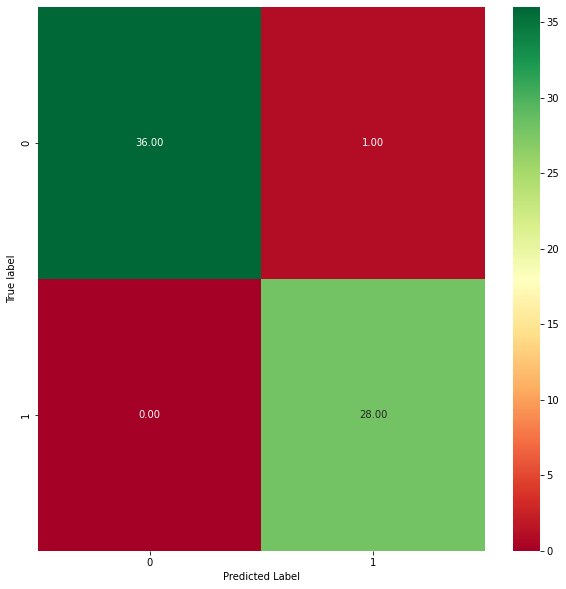

In [ ]:
plot_cm(y_test,y_pred)

In [ ]:
print(precision_score(y_test,y_pred))
print(recall_score(y_test,y_pred))
print(f1_score(y_test,y_pred))

0.9655172413793104
1.0
0.9824561403508771


The results are pretty good, but Let's do this again, but this time, let's use all of the data.

## Split into Train/Test - Second Iteration
We are going to split into Train/Test with all columns except size as our input variables and size as our target variable.

In [ ]:
X = df.iloc[:,0:-1]
y = df[['size']]

Now can split into train/test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.20, random_state=32)

In [ ]:
X_train.head()

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,delta_15,delta_13
111,Adelie,35.2,15.9,186.0,3050.0,FEMALE,8.81668,-25.95399
56,Adelie,41.8,19.4,198.0,4450.0,MALE,8.86853,-26.06209
109,Adelie,40.2,17.0,176.0,3450.0,FEMALE,9.30722,-25.61039
127,Adelie,40.2,17.1,193.0,3400.0,FEMALE,9.28810,-25.54976
108,Adelie,37.7,19.8,198.0,3500.0,MALE,9.11066,-26.42563


In [ ]:
y_train.sum()

size    90
dtype: int64

Set which attributes are numerical versus for categorical for the pipeline.

In [ ]:
num_attribs=['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g','delta_15','delta_13']
cat_attribs=['species','sex']

Set up a transformer to apply to train and test.

In [ ]:
col_transform = ColumnTransformer(transformers=[
                               ('num',StandardScaler(),num_attribs),
                               ('cat', OneHotEncoder(), cat_attribs)]
                  )


In [ ]:
pipeline = Pipeline([
                     ('trans', col_transform),
                     ('SVCLinear', SVC(kernel="linear", C=1, max_iter=100000)),
                     ])

In [ ]:
pipeline.fit(X_train,np.ravel(y_train))

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['bill_length_mm',
                                                   'bill_depth_mm',
                                                   'flipper_length_mm',
                                                   'body_mass_g', 'delta_15',
                                                   'delta_13']),
                                                 ('cat', OneHotEncoder(),
                                                  ['species', 'sex'])])),
                ('SVCLinear', SVC(C=1, kernel='linear', max_iter=100000))])

In [ ]:
y_pred = pipeline.predict(X_test)

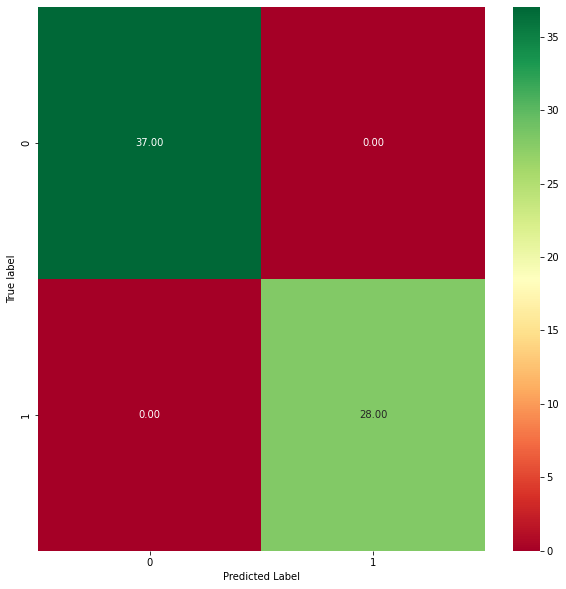

In [ ]:
plot_cm(y_test,y_pred)

In [ ]:
print(precision_score(y_test,y_pred))
print(recall_score(y_test,y_pred))
print(f1_score(y_test,y_pred))

1.0
1.0
1.0


## SVM Regression

## Split into Train/Test - Third Iteration
We are going to split into Train/Test with all columns except body mass as our input variables and body mass as our target variable. In this example, we'll do a regression problem instead of classification.

In [ ]:
df.columns

Index(['species', 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm',
       'body_mass_g', 'sex', 'delta_15', 'delta_13', 'size'],
      dtype='object')

In [ ]:
X = df[['species', 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm',
      'sex', 'delta_15', 'delta_13', 'size']]
y = df[['body_mass_g']]

Now can split into train/test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.20, random_state=32)

In [ ]:
X_train.head()

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,sex,delta_15,delta_13,size
111,Adelie,35.2,15.9,186.0,FEMALE,8.81668,-25.95399,0
56,Adelie,41.8,19.4,198.0,MALE,8.86853,-26.06209,0
109,Adelie,40.2,17.0,176.0,FEMALE,9.30722,-25.61039,0
127,Adelie,40.2,17.1,193.0,FEMALE,9.28810,-25.54976,0
108,Adelie,37.7,19.8,198.0,MALE,9.11066,-26.42563,0


Set which attributes are numerical versus for categorical for the pipeline.

In [ ]:
num_attribs=['bill_length_mm','bill_depth_mm','flipper_length_mm','delta_15','delta_13']
cat_attribs=['species','sex']

Set up a transformer to apply to train and test.

In [ ]:
col_transform = ColumnTransformer(transformers=[
                               ('num',StandardScaler(),num_attribs),
                               ('cat', OneHotEncoder(), cat_attribs)],
                               remainder='passthrough'
                  )


In [ ]:
pipeline = Pipeline([
                     ('trans', col_transform),
                     ('SVR', SVR(kernel="linear", C=75, max_iter=100000, epsilon=0.0)),
                     ])

In [ ]:
pipeline.fit(X_train,np.ravel(y_train))

Pipeline(steps=[('trans',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['bill_length_mm',
                                                   'bill_depth_mm',
                                                   'flipper_length_mm',
                                                   'delta_15', 'delta_13']),
                                                 ('cat', OneHotEncoder(),
                                                  ['species', 'sex'])])),
                ('SVR',
                 SVR(C=75, epsilon=0.0, kernel='linear', max_iter=100000))])

In [ ]:
y_pred = pipeline.predict(X_test)

In [ ]:
y_pred

array([4043.3088443 , 4058.96902205, 3657.85794514, 4753.93080215,
       5405.53268217, 5294.25060099, 4079.78471232, 5465.72626234,
       5451.42791066, 5303.75136013, 4057.23020163, 5783.17499812,
       5530.12037174, 5691.63152788, 3522.64655061, 3824.87904717,
       5451.21247546, 3654.88944524, 3778.61255949, 5034.53023894,
       3328.68357949, 5184.11466564, 3844.91523977, 4049.72293352,
       3412.05970769, 4709.3835566 , 3959.22181035, 4385.92112417,
       4214.34087234, 3161.4808364 , 3680.07558888, 3296.61889425,
       4786.74016947, 3332.43374535, 5468.59783531, 3678.83769116,
       4215.49602056, 3192.12181882, 5415.49392093, 3838.83994306,
       3547.663014  , 5304.91671874, 4277.70347315, 2990.56469963,
       4107.46295247, 4044.27955207, 5570.91926916, 4766.89573611,
       3254.35528039, 4163.87026044, 5378.51233134, 3999.45201471,
       5495.76046805, 3896.50038204, 5355.55641306, 3816.31381761,
       3292.74642385, 4835.29726913, 4657.7758091 , 5252.04811

In [ ]:
print(mean_squared_error(y_test, y_pred)**(0.5))
print(mean_absolute_error(y_test, y_pred))

288.03292732681854
219.75393631572442


In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
lr_pipeline = Pipeline([
                     ('trans', col_transform),
                     ('lr', LinearRegression()),
                     ])

In [ ]:
lr_pipeline.fit(X_train,y_train)
y_pred_lr = lr_pipeline.predict(X_test)

In [ ]:
print(mean_squared_error(y_test, y_pred_lr)**(0.5))
print(mean_absolute_error(y_test, y_pred_lr))

289.87561541865057
224.04584196875635
